In [1]:
from pathlib import Path
import sys
import tables as tb
import datetime
import tonic
import tonic.transforms as transforms
import numpy as np
import itertools
from prosper.em import EM
from prosper.utils import create_output_path
from prosper.em.annealing import LinearAnnealing
from prosper.em.camodels.bsc_et import BSC_ET
from prosper.utils.datalog import dlog, StoreToH5, TextPrinter, StoreToTxt

# parameters
dataset_name = 'POKERDVS' # POKERDVS, NMNIST, NCARS or IBMGesture
build_timesurfaces = True
verbose = 1 # 0, 1, or 2 to print more information

# initialisation
save_location = Path('data/{}'.format(dataset_name.lower()))
filename = '{}'.format(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
output_path = create_output_path(filename)

## Building time surfaces

In [2]:
if build_timesurfaces:
    # time surface parameters
    surface_dimensions = [11,11] # surface dimensions not necessarily square
    time_constant = 20000 # decay time constant for time surfaces
    download_dataset = True # downloads the datasets before parsing
    decay='exp'
    save_location = Path('data/{}'.format(dataset_name.lower()))

    # initialising the time surface transform
    transform = transforms.Compose([transforms.ToTimesurface(surface_dimensions=surface_dimensions, tau=time_constant, decay=decay, merge_polarities=True)])

    # choosing event-based dataset
    if dataset_name == 'NCARS': # 304 x 240
        train_data = tonic.datasets.NCARS(save_to=str(save_location), train=True, download=download_dataset, transform=transform)
        test_data = tonic.datasets.NCARS(save_to=str(save_location), train=False, download=download_dataset, transform=transform)
    if dataset_name == 'POKERDVS': # 35 x 35
        train_data = tonic.datasets.POKERDVS(save_to=str(save_location), train=True, download=download_dataset, transform=transform)
        test_data = tonic.datasets.POKERDVS(save_to=str(save_location), train=False, download=download_dataset, transform=transform)
    elif dataset_name == "IBMGesture": # 128 x 128
        train_data = tonic.datasets.IBMGesture(save_to=str(save_location), train=True, download=download_dataset, transform=transform)
        test_data = tonic.datasets.IBMGesture(save_to=str(save_location), train=False, download=download_dataset, transform=transform)
    elif dataset_name == 'NMNIST': # 34 x 34
        train_data = tonic.datasets.NMNIST(save_to=str(save_location), train=True, download=download_dataset, transform=transform)
        test_data = tonic.datasets.NMNIST(save_to=str(save_location), train=False, download=download_dataset, transform=transform)    

    train_loader = tonic.datasets.DataLoader(train_data, batch_size=1, shuffle=True)
    test_loader = tonic.datasets.DataLoader(test_data, batch_size=1, shuffle=True)

    # parsing training dataset
    X_train, y_train, train_bin_counts   = [], [], []
    for surfaces, target in iter(train_loader):
        surfaces = surfaces.squeeze().numpy()
        surfaces = surfaces.reshape(surfaces.shape[0], -1)
        train_bin_counts.append(len(surfaces))
        X_train.extend(surfaces)
        y_train.extend(itertools.repeat(int(target),surfaces.shape[0]))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    # parsing test dataset
    X_test, y_test, test_bin_counts = [], [], []
    for surfaces, target in iter(test_loader):
        surfaces = surfaces.squeeze().numpy()
        surfaces = surfaces.reshape(surfaces.shape[0], -1)
        test_bin_counts.append(len(surfaces))
        X_test.extend(surfaces)
        y_test.extend(itertools.repeat(int(target),surfaces.shape[0]))
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # save data
    np.savez(save_location/'timesurfaces.npz',
             X_train=X_train,
             X_test=X_test,
             y_train=y_train,
             y_test=y_test,
             train_bin_counts=train_bin_counts,
             test_bin_counts=test_bin_counts)
    
    timesurfaces = {'X_train':X_train,
                    'X_test':X_test,
                    'y_train':y_train,
                    'y_test':y_test,
                    'train_bin_counts':train_bin_counts,
                    'test_bin_counts':test_bin_counts}

Using downloaded and verified file: data/pokerdvs/pips_train.tar.gz
Extracting data/pokerdvs/pips_train.tar.gz to data/pokerdvs
Using downloaded and verified file: data/pokerdvs/pips_test.tar.gz
Extracting data/pokerdvs/pips_test.tar.gz to data/pokerdvs


## training sparse coding model

In [3]:
# loading time surfaces when build_timesurfaces = False
if not build_timesurfaces:
    try:
        timesurfaces = np.load(save_location/'timesurfaces.npz')
    except:
        print('Generate and save some time surfaces first.')

H = 400 # Dimensionality of the model
D = timesurfaces['X_train'].shape[1] # dimensionality of observed data

# Approximation parameters for Expectation Truncation (It has to be Hprime>=gamma)
Hprime = 5
gamma = 3

# Import and instantiate a model
model = BSC_ET(D, H, Hprime, gamma)

# Configure DataLogger    
h5_list = ('T', # temperature for deterministic annealing (avoids local optima)
           'L', # log likelihood
           'pi', # prior
           'sigma', # standard deviation
           'W') # mean

# Stores things in an h5 file
dlog.set_handler(h5_list, StoreToH5, output_path+'/results.h5')

# print to terminal
if verbose > 1:
    print_list = ('T', 'L', 'pi', 'sigma')
    dlog.set_handler(print_list, TextPrinter)

# Choose annealing schedule
anneal = LinearAnnealing(20)
anneal['T'] = [(0, 5.), (.8, 1.)]
anneal['Ncut_factor'] = [(0, 0.), (0.5, 0.), (0.6, 1.)]
anneal['W_noise'] = [(0, np.std(timesurfaces['X_train']) / 2.), (0.7, 0.)]
anneal['anneal_prior'] = False

# initialise model parameters
training_dict = {'y': timesurfaces['X_train'], 'l': timesurfaces['y_train']}
model_params = model.standard_init(training_dict)
if verbose > 0:
    print("model defined")

em = EM(model=model, anneal=anneal)
em.data = training_dict
em.lparams = model_params
em.run()
if verbose > 0:
    print("em finished")
    
dlog.close()

model defined
em finished


## classification

In [4]:
# inference on training set
results_train = model.inference(anneal, em.lparams, training_dict)

start = 0
train_features, train_labels = [], []
for i in range(len(timesurfaces['train_bin_counts'])):
    stop = start + timesurfaces['train_bin_counts'][i]
    train_features.append(results_train['s'][start:stop, 0, :].mean(0))
    this_l = timesurfaces['y_train'][start:stop]
    assert (this_l == this_l[0]).all()
    train_labels.append(this_l[0])
    start = stop
train_features = np.array(train_features)
train_labels = np.array(train_labels)

# inference on test set
test_dict = {'y': timesurfaces['X_test']}
results_test = model.inference(anneal, em.lparams, test_dict)

start = 0
test_features, test_labels = [], []
for i in range(len(timesurfaces['test_bin_counts'])):
    stop = start + timesurfaces['test_bin_counts'][i]
    test_features.append(results_test['s'][start:stop, 0, :].mean(0))
    this_l = timesurfaces['y_test'][start:stop]
    
    assert (this_l == this_l[0]).all()
    test_labels.append(this_l[0])
    start = stop
    
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# classification
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(solver='lbfgs', multi_class='auto',max_iter=1000)
logreg.fit(train_features,train_labels)
score = logreg.score(test_features, test_labels)

# print mean score
print('Logistic Regression Classifier: %s' % score)
np.save(output_path+'/classification.npy', score)

if verbose > 1:
    lr_tr_pred = logreg.predict(train_features)
    lr_te_pred = logreg.predict(test_features)

    print("Training dataset results for classifier: \n\n%s\n\n%s\n" % (logreg, metrics.classification_report(train_labels, lr_tr_pred)))
    print("Confusion matrix:\n\n%s\n"  % metrics.confusion_matrix(train_labels, lr_tr_pred))
    print("-----------------------------------------------------")
    print("\nTest dataset results for classifier: \n\n%s\n\n%s\n" % (logreg, metrics.classification_report(test_labels, lr_te_pred)))
    print("Confusion matrix:\n\n%s\n" % metrics.confusion_matrix(test_labels, lr_te_pred))

Logistic Regression Classifier: 0.95


## Visualisation

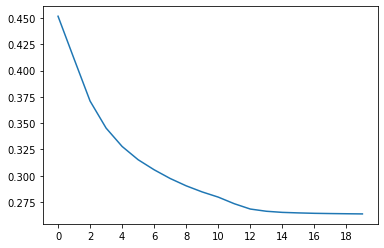

<Figure size 432x288 with 0 Axes>

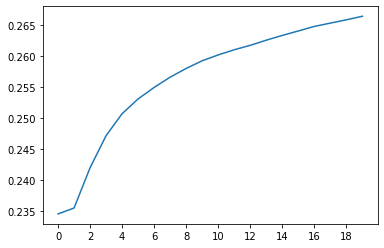

iteration 0


<Figure size 432x288 with 0 Axes>

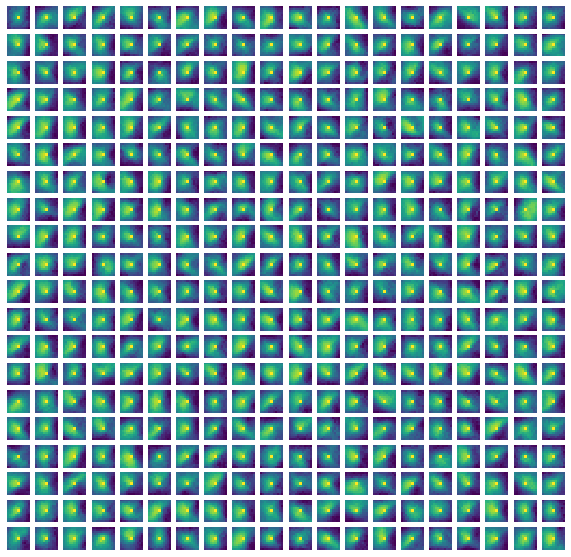

iteration 1


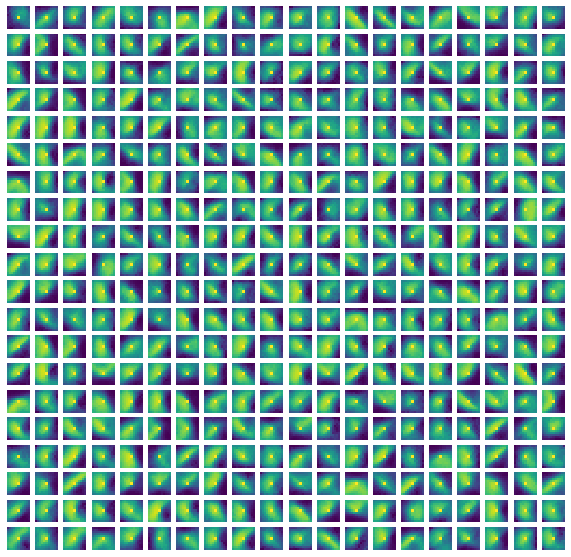

iteration 2


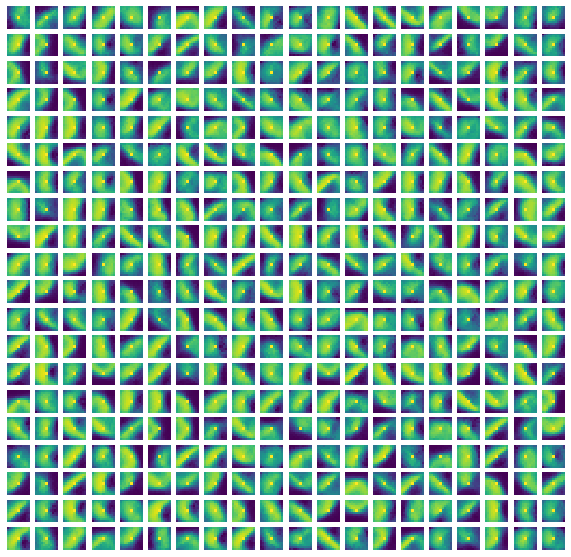

iteration 5


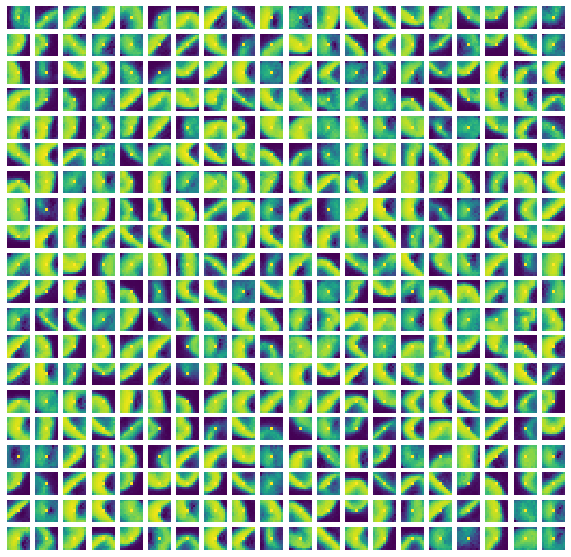

iteration 10


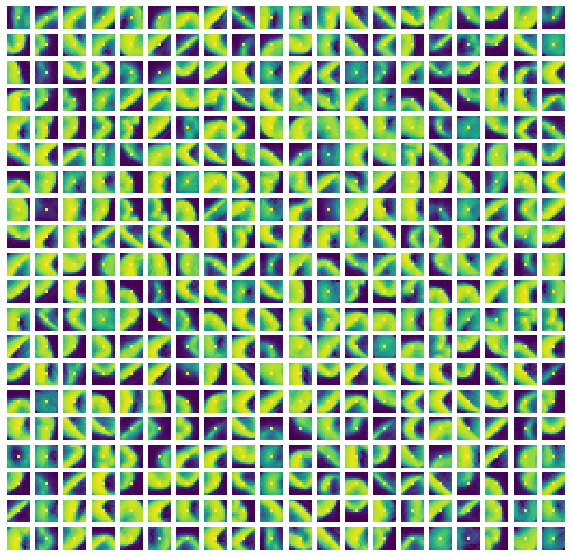

iteration 19


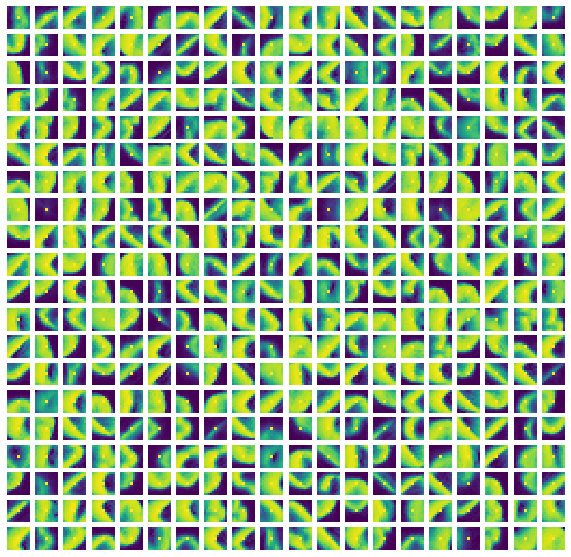

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns

file=tb.open_file("output/latest/results.h5", mode='r')
# file=tb.open_file(output_path+"results.h5", mode='r')

# read parameters
Ws=file.root.W.read()
pi=file.root.pi.read()
sigma=file.root.sigma.read()

# sigma plot
plt.figure()
plt.plot(sigma)
locator = matplotlib.ticker.MultipleLocator(2)
plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.show()
plt.savefig(output_path+'sigma.pdf')

# pi plot
fig = plt.figure(2)
plt.plot(pi*100)
locator = matplotlib.ticker.MultipleLocator(2)
plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.show()
plt.savefig(output_path+'pi.pdf')

# dictionary of features
for ind in [0,1,2,5,10,-1]:
    print("iteration", Ws.shape[0]-1) if ind == -1 else print("iteration", ind)
    fig=plt.figure(figsize=(10,10))
    rows=np.ceil(np.sqrt(Ws.shape[-1]))
    cols=np.ceil(np.sqrt(Ws.shape[-1]))
    D=int(np.sqrt(Ws.shape[-2]))
    
    for i in range(Ws.shape[-1]):    
        ax= fig.add_subplot(rows,cols,i+1)
        ax.imshow(Ws[ind,:,i].reshape((D,D)),interpolation='nearest')
        ax.axis('off')
    plt.savefig(output_path+'dictionary_{}.pdf'.format(ind))
    plt.show()